In [1]:
import torch as torch
import torch.nn as nn

In [12]:
class BasicBlock(nn.Module):
    
    def __init__(self, in_channels, out_channels, stride=1):
        super().__init__()
        self.residual_function = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3,
                     stride=stride, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels,kernel_size=3,
                     padding=1, bias=False),
            nn.BatchNorm2d(out_channels)
        )
        
        self.shortcut = nn.Sequential()
        
        if stride!=1 or in_channels!=out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1,
                         stride=stride, bias=False),
                nn.BatchNorm2d(out_channels)
            )
        
    def forward(self, x):
        return nn.ReLU(inplace=True)(self.residual_function(x) + self.shortcut(x))
    
    
class ResNet(nn.Module):
    
    def __init__(self, block, num_blocks, num_classes=100):
        super().__init__()
        
        self.in_channels = 64
        
        self.conv1 = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True))
        self.conv2_x = self._make_layer(block, 64, num_blocks[0], 1)
        self.conv3_x = self._make_layer(block, 128, num_blocks[1], 2)
        self.conv4_x = self._make_layer(block, 256, num_blocks[2], 2)
        self.conv5_x = self._make_layer(block, 512, num_blocks[3], 2)
        
        self.avg_pool = nn.AdaptiveAvgPool2d((1,1))
        self.fc = nn.Linear(512, num_classes)
        
    def _make_layer(self, block, out_channels, num_blocks, stride):
        strides = [stride] + [1]*(num_blocks - 1)
        layers = []
        
        for stride in strides:
            layers.append(block(self.in_channels, out_channels, stride))
            self.in_channels = out_channels

        return nn.Sequential(*layers)
    
    def forward(self, x):
        o = self.conv1(x)
        o = self.conv2_x(o)
        o = self.conv3_x(o)
        o = self.conv4_x(o)
        o = self.conv5_x(o)
        o = self.avg_pool(o)

        o = o.view(o.size(0), -1)
        o = self.fc(o)
        
        return o
    
    
model = ResNet(BasicBlock, [2,2,2,2])

In [21]:
import torch
import torchvision
import torchvision.transforms as transforms

transform = transforms.Compose(
    [transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

trainset = torchvision.datasets.CIFAR10(root='../data', train=True,
                                       download=False, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=1,
                                         shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='../data', train=False,
                                       download=False, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=1,
                                         shuffle=True, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

torch.Size([1, 3, 32, 32])


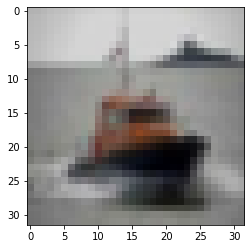

 ship


In [25]:
import matplotlib.pyplot as plt
import numpy as np

def imshow(img):
    img = img/2 + 0.5
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()
    
dataiter = iter(trainloader)
images, labels = dataiter.next()
print(images.shape)
imshow(torchvision.utils.make_grid(images))
print(' '.join('%5s' % classes[labels[j]] for j in range(1)))
plt.show()

In [ ]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

for epoch in range(1):
    
    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        inputs, labels = data
        
        optimizer.zero_grad()
        
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        
        optimizer.step()
        
        running_loss += loss.item()
        if i % 2000 == 1999:
            print('[%d, %5d] loss: %.3f' %
                 (epoch + 1, i + 1, running_loss / 2000))
            running_loss = 0.0
            
print('Finished Training')